# Projet 7: Implémentez un modèle de scoring (choix du modèle de scoring)

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Chargement des données](#load)
3. [Modélisation](#model)

## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [1]:
# builtin
#import os
import time
#from os import listdir

# data
import numpy as np
import pandas as pd

# Fonctions personnelles
import fct_eda
import fct_preprocessing
import fct_model

# Update Fonctions personnelles
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# viz
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
import seaborn as sns

# stats
#from scipy.stats import chi2_contingency #Chi2
#import pingouin as pg # Test Chi2 d'independance

# models
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Balancing data
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as pipe


from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import set_config
set_config(display='diagram')
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, fbeta_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

#import joblib # sauvegarde des modèles
#from mlflow.models.signature import infer_signature
#from urllib.parse import urlparse
import mlflow
import mlflow.sklearn


#import gc
#from contextlib import contextmanager

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('ignore')

#
#from sklearn.metrics import roc_auc_score, roc_curve
#from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
# Configuration Pandas
pd_option_dictionary = {
    'display.max_rows': 500,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': None,
    'display.float_format' : '{:.2f}'.format,
}

for pat, value in pd_option_dictionary.items():
    pd.set_option(pat, value)

## Chargement des données <a class="anchor" id="load"></a>

In [3]:
df = fct_preprocessing.main()

Application_train shape: (252133, 125)
Processing application_train fait en 15.0s 
Bureau shape: (305807, 66)
Processing bureau et bureau_balance fait en 49.0s 
Previous applications shape: (338384, 176)
Processing previous_applications fait en 112.0s 
Pos-cash balance shape: (337252, 17)
Processing POS-CASH balance fait en 33.0s 
Installments payments shape: (339587, 10)
Processing installments payments fait en 39.0s 
Credit card balance shape: (103558, 69)
Processing credit card balance fait en 67.0s 


In [4]:
# Vérification que le dataset consolidé ne contient pas de NaN
fct_eda.shape_total_nan(df)

Nombre de lignes: 252133
Nombre de colonnes: 394
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


## Modélisation <a class="anchor" id="model"></a>

Nous cherchons à classer les demandes en **crédit accordé ou refusé**. Il s'agit donc d'un modèle de **classification**.

### Choix des features <a class="anchor" id="feats"></a>

### Traitement des données déséquilibrées <a class="anchor" id="inbalanced"></a>

Lors de l'analyse exploratoire, nous avons remarqué que les données étaient très **déséquilibrées** entre les défaillants et non défaillants. Les non défaillants sont largement sur représentés (> 91%).

La plupart des modèles de Machine Learning vont **ignorer la classe minoritaire** et donc avoir des **performances médiocres** dans cette classe alors qu'en général c'est la performance de la classe minoritaire qui est la plus importante.

Une des approches pour traiter les ensembles de données déséquilibrés consiste à suréchantillonner la classe minoritaire. La méthode la plus simple est de **dupliquer les exemples de la classe minoritaire** même si aucune information n'est ajoutée au modèle.

Il est également possible de **pondérer les classes** c'est à dire ajuster la fonction de coût du modèle de manière à ce qu'une mauvaise classification d'une observation de la classe minoritaire soit plus lourdement pénalisée qu'une mauvaise classification d'une observation de la classe majoritaire. Cette approcge contribue à améliorer la précision du modèle en rééquilibrant la distribution des classes. Comme aucun nouveau point de données n'est créé, la méthode doit ête utilisée conjointement avec d'autres méthodes comme le suréchantillonnage par exemple.

Au lieu de cela, de nouveaux **exemples peuvent être synthétisés à partir des exemples existants**. Il s'agit d'un type d'augmentation de données pour la classe minoritaire appelé **SMOTE** pour (Synthetic Minority Oversampling Technique ou Technique de suréchantillonnage synthétique des minorités).

Un **exemple aléatoire de la classe minoritaire** est choisi et les k plus proches voisins sont trouvés (avec k = 5 en général). **Un voisin est choisi au hasard** et un segment est tracé entre les 2 points.
 
Il est recommandé d'utiliser d'abord un **sous-échantillonnage aléatoire** pour réduire le nombre d'exemples dans la classe minoritaire puis d'utiliser **SMOTE** pour suréchantillonner la classe minoritaire afin d'équilibrer la distribution des classes. C'est une approche efficace car les nouveaux exemples synthétiques de la classe minoritaire sont plausibles (proches dans l'espace des caractéristiques des exemples existants de la classe minoritaire).

L'inconvénient général serait que les exemples synthétiques sont créés sans tenir compte de la classe majoritaire.

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

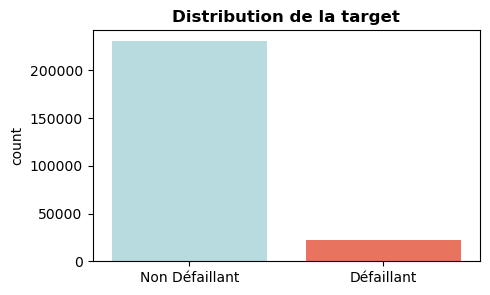

In [13]:
# Distribution de la target
plt.figure(figsize=(5,3))
sns.countplot(x = 'TARGET', data = df, palette=['powderblue', 'tomato'])
plt.title('Distribution de la target', fontweight='bold', fontsize = 12)
x = [0, 1]
plt.xticks(x, ['Non Défaillant', 'Défaillant'])
plt.xlabel('');

In [39]:
Counter(df['TARGET'])

Counter({1: 21835, 0: 230298})

In [20]:
# Sur échantillonnage de la classe minoritaire (10% de la classe majoritaire ~= 23000)
oversampler = SMOTE(sampling_strategy=0.1)

In [21]:
# Sous échantillonnage pour réduire la classe majoritaire (50% de plus que la classe minoritaire ~= 46000
undersampler = RandomUnderSampler(sampling_strategy=0.5)

In [35]:
# Création pipeline pour appliquer les deux étapes précédentes à tour de rôle
pipeline_balancing = pipe(steps=[
    ('over', oversampler),
    ('under', undersampler)])

In [36]:
# Choix des features et de la target
feats = [f for f in df.columns if f not in ['TARGET']]
target = df['TARGET']

In [37]:
# Transformation du dataset
df_balanced, target_balanced = pipeline_balancing.fit_resample(df[feats], target)

In [38]:
Counter(target_balanced)

Counter({0: 46058, 1: 23029})

Ces différentes étapes seront intégrées dans la pipeline du modèle.

- https://www.youtube.com/watch?v=Kp31wfHpG2c
- https://github.com/scikit-learn-contrib/imbalanced-learn
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/   
- https://vitalflux.com/class-imbalance-class-weight-python-sklearn/

### Sélection des données d'entrainement et de test <a class="anchor" id="train_test"></a>

En Machine Learning il ne faut jamais valider un modèle sur les données qui ont servi à son entrainement. Le modèle doit être testé sur des données qu'il n'a jamais vues. On aura ainsi une idée de sa performance future. Le dataset sera mélangé de façon aléatoire avant d'être divisé en deux parties:
- un **train set** dont les données sont utilisées pour **entrainer le modèle**
- un **test set** réservé uniquement à **l'évaluation du modèle**

In [5]:
# Choix des features et de la target
feats = [f for f in df.columns if f not in ['TARGET']]
target = df['TARGET']

In [6]:
# Jeu d'entrainement (80%) et de validation (20%)
X_train, X_test, y_train, y_test = train_test_split(df[feats], df['TARGET'],
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 42)
print(f"Nb de lignes des données d'entrainement: {len(X_train)} \nNb de lignes des données de validation: {len(X_test)}")

Nb de lignes des données d'entrainement: 201706 
Nb de lignes des données de validation: 50427


### Pipeline, optimisation et entrainement des modèles <a class="anchor" id="pipe"></a>

Nous allons dans un premier temps créer une **pipeline** pour chacun de nos modèles. Cette pipeline va nous permettre d'affecter des étapes de preprocessing à nos données, c'est à dire des transformations comme le **traitement des données déséquilibrées**, la **standardisation**, et de choisir le **type de modèle**.

Cette pipeline sera ensuite intégrée dans une fonction d'optimisation et d'entrainement qui va utiliser la **validation croisée** pour tester la robustesse du modèle prédictif en répétant la procédure de split. Elle donnera plusieurs erreurs d'apprentissage et de test et donc une **estimation de la variabilité de la performance de généralisation du modèle**. 

Nous allons comparer l'erreur de validation avec l'erreur d'entrainement. On va créer un **validation set** qui va nous permettre d'optimiser les réglages du modèle qui donne les meilleures performances tout en gardant de côté les données du test set pour évaluer le modèle sur des données qu'il n'aura jamais vues.

Le réglage des hyperparamètres s'effectuera soit à l'aide du  **GridSearchCV** qui va tester toutes les combinaisons possibles d'hyperparamètres afin de trouver celles qui vont minimiser le plus l'erreur (méthode exhaustive très **coûteuse en termes de puissance de calcul et de temps**), soit du **RandomizedSearchCV** qui va sélectionner des combinaisaons aléatoires d'hyperparamètres. Cette méthode est **un peu moins précise mais beaucoup plus rapide**. Elle sera utilisée pour les modèles plus complexes.

Enfin, pour évaluer la **performance réelle de nos modèles**, nous calculerons les metrics choisis sur les données de test.

### Choix des scores <a class="anchor" id="scores"></a>

Si l'on se réfère au fichier de description des colonnes:
- **1** => clients a des difficultés de paiement, il a eu un retard de paiement de plus de X jours sur au moins une des Y premières échéances du prêt dans notre échantillon (**défaillant**)
- **0** => tous les autres cas (**non défaillant**)

Sur une matrice de confusion, les défaillants représentent la classe positive (Y=1) et les non défaillants la classe négative (Y=0).

Comme il serait extrêment coûteux pour la banque d'accorder un crédit à un client défaillant qui ne le rembourserait pas ou en partie, il nous faut **minimiser le nombre de faux négatifs** c'est à dire un client prédit non défaillant alors qu'il est défaillant.

Il faut également tâcher de **minimiser les faux positifs** c'est à dire prédire qu'un client est défaillant alors qu'il ne l'est pas (risque de perte de clients, de manque à gagner).

Cependant, un faux positif n'a pas le même coût qu'un faux négatif. Ce dernier est beaucoup plus coûteux pour la banque. **Nous accorderons donc plus de poids aux faux négatifs** (fonction coût métier) et supposerons qu'ils sont 10 fois plus coûteux que les faux positifs (eux même 5 fois plus coûteux que les vrais positifs et vrais négatifs). Les modèles seront évalués sur ce score métier.

Le **Rappel (Recall)** qui mesure le taux de vrais positifs est à favoriser au détriment de la précision qui est la capacité du classificateur à ne pas étiqueter comme positif un échantillon qui est négatif.

Pour faire cela, nous allons nous baser sur le **F-beta score** qui est la moyenne harmonique pondérée de la précision et du rappel. Le paramètre bêta détermine le poids du rappel dans le score. Lorsqu'il est suppérieur à un, il favorise le rappel.

Nous mettrons également l'**accuracy** et l'**AUC** comme éléments de comparaison. Le **temps d'entrainement** sera également tracké.

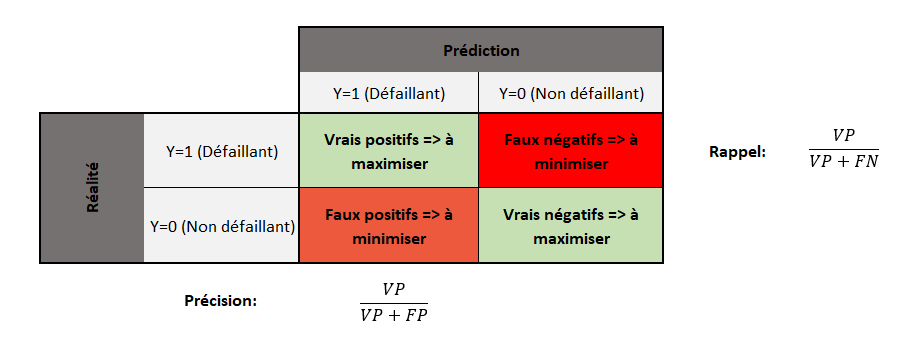

### Modèle Baseline: Dummy classifier <a class="anchor" id="dummy"></a>

Ce classificateur fait des prédictions en utilisant des règles simples. Il est utile comme **base de référence simple** à comparer avec d'autres classificateurs et ne sera pas optimisé. Il ignore les variables en entrée et par conséquent, n'utilise aucune information provenant des features. Il n'y a donc **pas besoin de transformer au préalable nos features**.

In [7]:
def pipeline_model(model, numeric_features, numeric_transformer):

    # Transformations à effectuer sur nos variables
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),])

    # Définition de la pipeline du modèle: étapes de preprocessing + classifier
    pipeline_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)])
    
    return pipeline_model

In [47]:
def pipeline_model_balanced(model, numeric_features, numeric_transformer,
                            oversampling_strategy = 0.1, undersampling_strategy = 0.5):

    # Sur échantillonnage de la classe minoritaire (10% de la classe majoritaire ~= 23000)
    oversampler = SMOTE(sampling_strategy = oversampling_strategy)

    # Sous échantillonnage pour réduire la classe majoritaire (50% de plus que la classe minoritaire ~= 46000
    undersampler = RandomUnderSampler(sampling_strategy = undersampling_strategy)
    
    # Transformations à effectuer sur nos variables
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),])
    
    # Définition de la pipeline du modèle: étapes de preprocessing + classifier
    pipeline_model_balanced = pipe(steps=[
        ('over', oversampler),
        ('under', undersampler),
        ('preprocessor', preprocessor),
        ('classifier', model)])
    
    return pipeline_model_balanced

In [8]:
def optimize_and_train_model(pipeline_model, xtrain, ytrain, params, scoring):
    
    _ = pipeline_model.fit(xtrain, ytrain)


    # Réglage automatique des meilleurs hyperparamètres avec GridSearchCV
    inner_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
    model_grid_cv = GridSearchCV(pipeline_model, 
                                 param_grid = params, 
                                 cv = inner_cv, 
                                 scoring = scoring)

    model_grid_cv.fit(xtrain, ytrain)
    
    best_model = model_grid_cv.best_estimator_
    best_params = model_grid_cv.best_params_

    return best_model, best_params

In [9]:
def score_metier(ytest, y_pred, poids_vp=1, poids_fn=-10, poids_fp=-5, poids_vn=1):
    
    # Matrice de confusion transformée en array avec affectation aux bonnes catégories
    (vn, fp, fn, vp) = confusion_matrix(ytest, y_pred).ravel()
    
    # Cas rééls
    actual_cases = (vp * poids_vp) + (fn * poids_fn) + (fp * poids_fp) + (vn * poids_vn)
    
    # Cas les plus coûteux: Accorder un crédit à un client défaillant (FN) + 
    # ne pas accorder un crédit à un client non défaillant (FP)
    worst_cases = (vp + fn) * poids_fn + (fp + vn) * poids_fp
    
    # Cas les plus rentables: Ne pas accorder un crédit à un client défaillant (VP) + 
    # accorder un crédit à un client non défaillant (VN)
    best_cases = (vp + fn) * poids_vp + (fp + vn) * poids_vn
    
    # Normalisation du score (échelle de 0 à 1) => (valeurs - minimum) / (maximum - minimum)
    norm_score = (actual_cases - worst_cases) / (best_cases - worst_cases)
    
    return norm_score

In [10]:
def eval_metrics(best_model, xtest, ytest):
    
    y_pred = best_model.predict(xtest)
    
    score_biz = score_metier(ytest, y_pred, poids_vp=1, poids_fn=-10, poids_fp=-5, poids_vn=1)
    recall = recall_score(ytest, y_pred)
    precision = precision_score(ytest, y_pred)
    accuracy = accuracy_score(ytest, y_pred)
    auc = roc_auc_score(ytest, y_pred)
    
    return score_biz, recall, precision, accuracy, auc, y_pred

In [69]:
def matrice_confusion(ytest, ypred, model_name):
    plt.figure(figsize=(5, 5))
    cm = confusion_matrix(ytest, ypred)
    sns.heatmap(cm,
                xticklabels=['Y=0 (Non défaillant)', 'Y=1 (Défaillant)'],
                yticklabels=['Y=0 (Non défaillant)', 'Y=1 (Défaillant)'],
                annot=True,
                fmt='d', 
                linewidth=.5, 
                cmap = sns.cubehelix_palette(as_cmap=True), cbar=False)
    plt.title(f'Matrice de confusion: {model_name}')
    plt.ylabel('Réalité')
    plt.xlabel('Prédiction')
    plt.show()

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DummyClassifier Model with param strategy = most_frequent

Score_metier: 0.85
Recall: 0.00
Precision: 0.00
Accuracy: 0.91
AUC: 0.50
Train time: 11.62


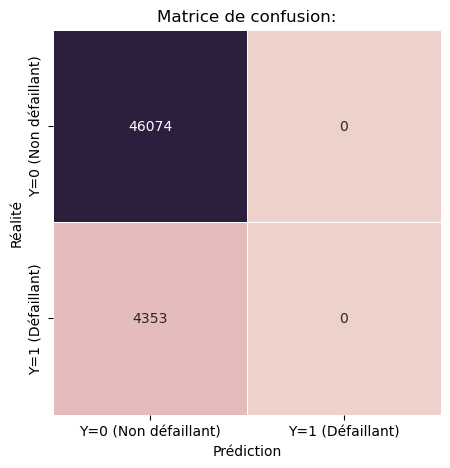

In [12]:
# Modèle
start_Dummy = time.time()
model = DummyClassifier()

# Sélection des hyperparamètres
params = {'strategy' : ['most_frequent', 'prior', 'stratified', 'uniform'],}
scoring = make_scorer(score_metier)

best_model_Dummy, best_params_Dummy = optimize_and_train_model(pipeline_model = model,
                                                               xtrain = X_train,
                                                               ytrain = y_train,
                                                               params = params,
                                                               scoring = scoring)


duration_Dummy = time.time() - start_Dummy
    
# Evaluation du modèle
(score_biz, recall, precision, accuracy, auc, y_pred) = eval_metrics(best_model = best_model_Dummy,
                                                                     xtest = X_test,
                                                                     ytest = y_test)
    
print(f"DummyClassifier Model with param strategy = {best_params_Dummy['strategy']}")
print()
print(f"Score_metier: {score_biz:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Train time: {duration_Dummy:.2f}")

matrice_confusion(y_test, y_pred, 'DummyClassifier')

#### Données équilibrées

DummyClassifier Model with param strategy = most_frequent

Score_metier: 0.85
Recall: 0.00
Precision: 0.00
Accuracy: 0.91
AUC: 0.50
Train time: 180.42


C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


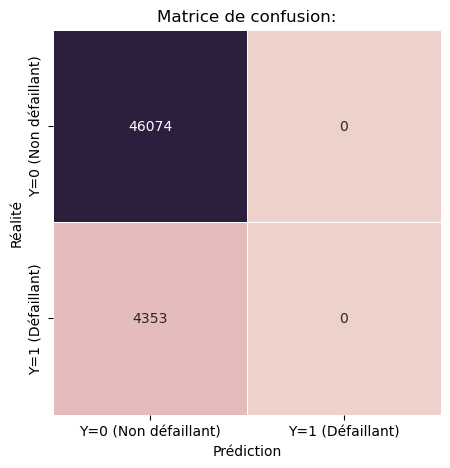

In [49]:
# Modèle
start_Dummy = time.time()



model = pipeline_model_balanced(model = DummyClassifier(),
                                numeric_features = feats,
                                numeric_transformer = StandardScaler(),
                                oversampling_strategy = 0.1,
                                undersampling_strategy = 0.5)

# Sélection des hyperparamètres
params = {'classifier__strategy' : ['most_frequent', 'prior', 'stratified', 'uniform'],}
scoring = make_scorer(score_metier)

best_model_Dummy, best_params_Dummy = optimize_and_train_model(pipeline_model = model,
                                                               xtrain = X_train,
                                                               ytrain = y_train,
                                                               params = params,
                                                               scoring = scoring)


duration_Dummy = time.time() - start_Dummy
    
# Evaluation du modèle
(score_biz, recall, precision, accuracy, auc, y_pred) = eval_metrics(best_model = best_model_Dummy,
                                                                     xtest = X_test,
                                                                     ytest = y_test)
    
print(f"DummyClassifier Model with param strategy = {best_params_Dummy['classifier__strategy']}")
print()
print(f"Score_metier: {score_biz:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Train time: {duration_Dummy:.2f}")

matrice_confusion(y_test, y_pred)

**Démarche MLOps**

In [ ]:
!mlflow --version

In [ ]:
# Création du tracking cad où MLFlow sauvegarde les runs
mlflow.set_tracking_uri("file:///Users/milie/01_PYTHON/4. OPEN_CLASSROOMS/07_PROJET_7/mlruns")

# Création d'un experiment
experiment_id = mlflow.create_experiment("Training binary classifier")


with mlflow.start_run(experiment_id = experiment_id):
    start_Dummy = time.time()
    model = DummyClassifier()

    # Sélection des hyperparamètres
    params = {'strategy' : ['most_frequent', 'prior', 'stratified', 'uniform'],}
    scoring = make_scorer(recall_score)

    best_model_Dummy, best_params_Dummy = optimize_and_train_model(pipeline_model = model,
                                                                    xtrain = X_train,
                                                                    ytrain = y_train,
                                                                    params = params,
                                                                    scoring = scoring)


    duration_Dummy = time.time() - start_Dummy
    
    # Evaluation du modèle
    (recall, precision, accuracy, auc) = eval_metrics(best_model = best_model_Dummy,
                                                      xtest = X_test,
                                                      ytest = y_test)
    
    print(f"DummyClassifier Model with param strategy = {best_params_Dummy['strategy']}")
    print()
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"AUC: {auc:.2f}")
    print(f"Train time: {duration_Dummy:.2f}")
    
    # log des paramètres et scores à chaque fois que le modèle est lancé
    mlflow.log_param("strategy", best_params_Dummy['strategy'])
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("Tps_entrainement", duration_Dummy)
    
    mlflow.sklearn.log_model(best_model_Dummy, "dummyclassifier")

### Régression logistique <a class="anchor" id="reglog"></a>

La régression logistique est un modèle statistique qui permet d'étudier la **relation entre une variable binaire** dite variable dépendante / cible et **une ou plusieurs variables indépendantes**.

Il s'agit d'un **modèle linéaire** généralisé utilisant une fonction logistique comme fonction de lien. Il permet également de prédire la **probabilité qu'un événement arrive ou non** à partir de l'optimisation des coefficients de régression. Lorsque la valeur est > à un seuil, l'événement est susceptible de se produire alors que lorsque cette valeur est < au même seuil, il ne l'est pas.

Nous allons tenter d'optimiser ce modèle en jouant sur les **features**, le traitement du **déséquilibre des classes** et les **hyperparamètres** via **cross validation** et **GridSearch**:
- penalty: pénalité
- solver: algorithme à utiliser pour l'optimisation
- C : force de la pénalité (valeurs plus petites => régularisation plus forte)

In [91]:
# Choix des features
feats_reglog = ['DAYS_EMPLOYED_PERC', 'CREDIT_GOODS_PERC', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON',
                'DEBT_RATIO', 'PAYMENT_RATE']

#### Modélisation sur données non équilibrées

In [97]:
def best_model(model, xtrain, numeric_features, numeric_transformer, ytrain, params, scoring):
    start = time.time()
    model = pipeline_model(model = model,
                           numeric_features = numeric_features,
                           numeric_transformer = numeric_transformer)

    # Optimisation via cross validation & GridSearch
    best_model, best_params = optimize_and_train_model(pipeline_model = model,
                                                       xtrain = xtrain[numeric_features],
                                                       ytrain = ytrain,
                                                       params = params,
                                                       scoring = scoring)


    duration = time.time() - start
    
    display(best_model)
    print(f"Meilleurs hyperparamètres: {best_params}")
    print(f"Durée d'entrainement: {duration:.2f} s")
    
    return best_model, best_params, duration

In [98]:
(best_model_reglog, best_params_reglog, duration_reglog) = best_model(LogisticRegression(max_iter = 200, random_state=42),
                                                                      xtrain = X_train,
                                                                      numeric_features = feats_reglog,
                                                                      numeric_transformer = StandardScaler(),
                                                                      ytrain = y_train,
                                                                      params = {"classifier__penalty": ['l2', 'l1'],
                                                                                "classifier__solver": ['lbfgs', 'saga'],
                                                                                "classifier__C": [100, 10, 1.0, 0.1, 0.01],},
                                                                      scoring = make_scorer(score_metier))

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['DAYS_EMPLOYED_PERC',
                                                   'CREDIT_GOODS_PERC',
                                                   'INCOME_CREDIT_PERC',
                                                   'INCOME_PER_PERSON',
                                                   'DEBT_RATIO',
                                                   'PAYMENT_RATE'])])),
                ('classifier',
                 LogisticRegression(C=100, max_iter=200, random_state=42))])

Meilleurs hyperparamètres: {'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Durée d'entrainement: 332.88 s


Evaluation sur les données de test:

Score_metier: 0.85
Recall: 0.00
Precision: 1.00
Accuracy: 0.91
AUC: 0.50
Train time: 332.88


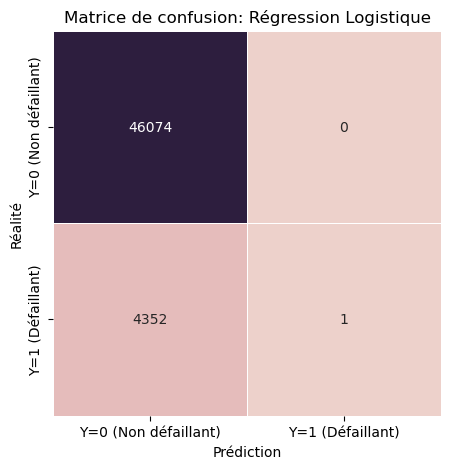

In [99]:
# Evaluation du modèle sur les données de test
(score_biz_reglog, recall_reglog, precision_reglog, accuracy_reglog, auc_reglog, y_pred_reglog) = eval_metrics(
    best_model = best_model_reglog,
    xtest = X_test[feats_reglog],
    ytest = y_test)
    
print('Evaluation sur les données de test:')
print()
print(f"Score_metier: {score_biz_reglog:.2f}")
print(f"Recall: {recall_reglog:.2f}")
print(f"Precision: {precision_reglog:.2f}")
print(f"Accuracy: {accuracy_reglog:.2f}")
print(f"AUC: {auc_reglog:.2f}")
print(f"Train time: {duration_reglog:.2f}")

matrice_confusion(y_test, y_pred_reglog, 'Régression Logistique')

In [100]:
dic_df_recap = {'Modèle':[best_model_reglog['classifier']],
                'Features':[feats_reglog],
                'Best_Params':[best_params_reglog],
                'Score_metier':[score_biz_reglog],
                'Recall':[recall_reglog], 
                'Precision':[precision_reglog], 
                'Accuracy':[accuracy_reglog], 
                'AUC':[auc_reglog], 
                "Train_Time": [duration_reglog],}
df_recap = pd.DataFrame(data = dic_df_recap)

In [101]:
df_recap

,Modèle,Features,Best_Params,Score_metier,Recall,Precision,Accuracy,AUC,Train_Time
0,"LogisticRegression(C=100, max_iter=200, random_state=42)","[DAYS_EMPLOYED_PERC, CREDIT_GOODS_PERC, INCOME_CREDIT_PERC, INCOME_PER_PERSON, DEBT_RATIO, PAYMENT_RATE]","{'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}",0.85,0.00,1.00,0.91,0.50,332.88


In [103]:
def best_model(model_name, model, xtrain, numeric_features, numeric_transformer, ytrain, params, scoring, xtest, ytest):
    start = time.time()
    model = pipeline_model(model = model,
                           numeric_features = numeric_features,
                           numeric_transformer = numeric_transformer)

    # Optimisation via cross validation & GridSearch
    best_model, best_params = optimize_and_train_model(pipeline_model = model,
                                                       xtrain = xtrain[numeric_features],
                                                       ytrain = ytrain,
                                                       params = params,
                                                       scoring = scoring)


    duration = time.time() - start
    
    display(best_model)
    print(f"Meilleurs hyperparamètres: {best_params}")
    print(f"Durée d'entrainement: {duration:.2f} s")
    
    # Evaluation du modèle sur les données de test
    (score_biz, recall, precision, accuracy, auc, y_pred) = eval_metrics(
        best_model = best_model,
        xtest = xtest,
        ytest = ytest)
    
    print('Evaluation sur les données de test:')
    print()
    print(f"Score_metier: {score_biz:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"AUC: {auc:.2f}")
    print(f"Train time: {duration:.2f}")

    matrice_confusion(ytest, y_pred, 'model_name')
    
    dic_df_recap = {'Modèle':[model_name],
                    'Features':[numeric_features],
                    'Best_Params':[best_params],
                    'Score_metier':[score_biz],
                    'Recall':[Recall], 
                    'Precision':[precision], 
                    'Accuracy':[accuracy], 
                    'AUC':[auc], 
                    "Train_Time": [duration],}
    df_recap = pd.DataFrame(data = dic_df_recap)
    
    return best_model, df_recap

In [ ]:
best_model_reglog, df_recap_reglog = best_model(model_name='Régression Logistique',
                                                model=LogisticRegression(max_iter = 200, random_state=42),
                                                xtrain=X_train,
                                                numeric_features=feats_reglog,
                                                numeric_transformer=StandardScaler(),
                                                ytrain=y_train,
                                                params={"classifier__penalty": ['l2', 'l1'],
                                                        "classifier__solver": ['lbfgs', 'saga'],
                                                        "classifier__C": [100, 10, 1.0, 0.1, 0.01],},
                                                scoring=make_scorer(score_metier),
                                                xtest=X_test,
                                                ytest=y_test)

#### Modélisation sur données rééquilibrées: pondération des classes 

Chaque algorithme de classification SKlearn possède un paramètre appelé **class_weight** qui permet de gérer le déséquilibre des classes: 

In [102]:
(best_model_reglog, best_params_reglog, duration_reglog) = best_model(LogisticRegression(class_weight = 'balanced',
                                                                                         max_iter = 200,
                                                                                         random_state=42),
                                                                      xtrain = X_train,
                                                                      numeric_features = feats_reglog,
                                                                      numeric_transformer = StandardScaler(),
                                                                      ytrain = y_train,
                                                                      params = {"classifier__penalty": ['l2', 'l1'],
                                                                                "classifier__solver": ['lbfgs', 'saga'],
                                                                                "classifier__C": [100, 10, 1.0, 0.1, 0.01],},
                                                                      scoring = make_scorer(score_metier))

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet7\lib\sit

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['DAYS_EMPLOYED_PERC',
                                                   'CREDIT_GOODS_PERC',
                                                   'INCOME_CREDIT_PERC',
                                                   'INCOME_PER_PERSON',
                                                   'DEBT_RATIO',
                                                   'PAYMENT_RATE'])])),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=200, penalty='l1', random_state=42,
                                    solver='saga'))])

Meilleurs hyperparamètres: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Durée d'entrainement: 743.99 s


#### Modélisation sur données rééquilibrées: sur-échantillonnage + pondération des classes 

In [ ]:
Nous allons effectuer un sur-échantillonnage de la classe minoritaire puis tester différentes pondérations:

#### Modélisation sur données rééquilibrées: sous échantillonage + SMOTE

In [ ]:
# Modèle
start_RegrLog = time.time()
model = pipeline_model(model = LogisticRegression(),
                       numeric_features = feats,
                       numeric_transformer = StandardScaler())

# Sélection des hyperparamètres
params = {"classifier__penalty": ['l2', 'l1'],}
scoring = make_scorer(recall_score)

best_model_RegrLog, best_params_RegrLog = optimize_and_train_model(pipeline_model = model,
                                                                   xtrain = X_train[feats],
                                                                   ytrain = y_train,
                                                                   params = params,
                                                                   scoring = scoring)


duration_RegrLog = time.time() - start_RegrLog
    
# Evaluation du modèle
(recall, precision, accuracy, auc) = eval_metrics(best_model = best_model_RegrLog,
                                                  xtest = X_test[feats],
                                                  ytest = y_test)
    
print(f"DummyClassifier Model with param penalty = {best_params_RegrLog['classifier__penalty']}")
print()
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Train time: {duration_RegrLog:.2f}")

In [ ]:
_ = ConfusionMatrixDisplay.from_estimator(best_model_Dummy, X_test[feats], y_test, labels=[1, 0])

#### Traitement des données déséquilibrées

<div class="alert alert-block alert-warning">
    <p>Paramètre class_weight</p>
</div>

In [ ]:
https://vitalflux.com/class-imbalance-class-weight-python-sklearn/

### LightGBM <a class="anchor" id="lightgbm"></a>

Choix d'un modèle avec Feature importance pour explications.

In [ ]:
# Choix des features
feats = ['DAYS_EMPLOYED_PERC', 'CREDIT_GOODS_PERC', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON',
         'DEBT_RATIO', 'PAYMENT_RATE']

In [ ]:
start_Lgbm = time.time()

model = pipeline_model(model = LGBMClassifier(),
                       numeric_features = feats,
                       numeric_transformer = StandardScaler())

# Sélection des hyperparamètres
params = {"classifier__ scale_pos_weight": [1,2,6,12],}
scoring = {"Recall": make_scorer(recall_score),
           "Precision": make_scorer(precision_score),
           "Accuracy": make_scorer(accuracy_score),
           "AUC": "roc_auc"}

best_model_Lgbm = optimize_and_train_model(pipeline_model = model, 
                                              xtrain = X_train[feats],
                                              ytrain = y_train,
                                              params = params,
                                              scoring = scoring)


stop_Lgbm = time.time() - start_Lgbm
print(f"Temps d'entrainement: {stop_Lgbm:.2f}")

 



In [ ]:
#EXPERIMENT_NAME = "mlflow-default-risk"
#EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)

start_Dummy = time.time()
model = DummyClassifier()

# Sélection des hyperparamètres
params = {'strategy' : ['most_frequent', 'prior', 'stratified', 'uniform'],}
scoring = make_scorer(recall_score)

best_model_Dummy, best_params_Dummy = optimize_and_train_model(pipeline_model = model,
                                                                xtrain = X_train,
                                                                ytrain = y_train,
                                                                params = params,
                                                                scoring = scoring)


duration_Dummy = time.time() - start_Dummy
    
# Evaluation du modèle
(recall, precision, accuracy, auc) = eval_metrics(best_model = best_model_Dummy,
                                                    xtest = X_test,
                                                    ytest = y_test)
    
print(f"DummyClassifier Model with param strategy = {best_params_Dummy['strategy']}")
print()
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Train time: {duration_Dummy:.2f}")

# Start MLflow
with mlflow.start_run() as run:
#with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=RUN_NAME) as run:
    
    # Run id
    RUN_ID = run.info.run_id
    
    # log des paramètres et scores à chaque fois que le modèle est lancé
    mlflow.log_param("strategy", best_params_Dummy['strategy'])
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("Tps_entrainement", duration_Dummy)
    
    mlflow.sklearn.log_model(best_model_Dummy, "dummyclassifier")

In [ ]:
def df_suivi_scores(best_model, feats, best_params):
    dic_df_recap = {'Modèle':[best_model['classifier']],
                    'Features':[feats],
                    'Best_Params':[best_params_reglog],
                    'Score_metier':[score_biz_reglog] 
                
                
                "Temps d'entrainement": [duration_reglog],}
df_tfidf_pdesc_recap = pd.DataFrame(data = df_tfidf_pdesc_recap)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

https://datascience.stackexchange.com/questions/82780/how-to-implement-a-gridsearchcv-custom-scorer-that-is-dependent-on-a-training-fe

<div class="alert alert-block alert-success">
    <p>•	Finir la partie exploration et la transformation et choix des features 
•	Créer un environnement MLFlow permettant le tracking lors de l’entraînement des modèles, la visualisation et la comparaison via l’UI de MLFlow, ainsi que le stockage de manière centralisée des modèles.
o	Il faut au minimum le tracking des scores (scores métier, AUC), des hyperparamètres, des temps de traitement de fit et de prédiction, ainsi que le stockage de graphiques (ROC curve) et des modèles
•	Une fonction de tracking de logs 

Bonus (je te le mets pour que tu l'aies en tête mais je n'attends pas que tu le fasse tout de suite) :
•	Avant de construire les modèles, réfléchir à la fonction de coût métier : 
o	La problématique « métier » est de prendre en compte qu’un faux positifs (crédit non accordé à tort, donc manque à gagner de la marge pour la banque) n’a pas le même coût qu’un faux négatif (mauvais client à qui on accorde un prêt, donc perte sur le capital non remboursé). Un faux négatif est environ 10 fois plus coûteux qu’un faux positif. Les mesures techniques tels que le f1 score ne le prennent pas en compte.
o	Le score “métier” consiste à calculer une fonction de coût métier de type 10*FN + FP 
o	Les modèles et leur hyperparamètres seront optimisés via un GridSearchCV ou équivalent sur ce score, faire aussi l’accuracy ou l’AUC comme élément de comparaison (le garder en référence)
</p>
</div>

<div class="alert alert-block alert-warning">
    <p>Suppression des variables avec 30% ou plus de NaN</p>
</div>

<div class="alert alert-block alert-success">
    <p>A noter: ces pairs de variables étant fortement corrélées, il faudra penser à ne pas les prendre toutes dans notre modèle.</p>
</div>